## Census Data

In [188]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import folium
from shapely import BufferCapStyle

In [189]:
df = pd.read_csv('census_1km.csv', sep = ';')
df = df.drop(axis = 1, columns = ["Gitter_ID_1km *"])
df.head()

,x_mp_1km_1,y_mp_1km_1,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D
0,4314500,3367500,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0
1,4331500,3372500,3,-9.0,0.0,100.0,0.00,-1.0,-1.0,-9.0,-1.0
2,4315500,3378500,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0
3,4316500,3379500,3,-9.0,0.0,0.0,100.00,-1.0,-1.0,-1.0,-1.0
4,4335500,3379500,7,-9.0,-9.0,0.0,57.14,1.4,-1.0,-1.0,-1.0


In [190]:
# create geometry element from point coordinates
geometry = gpd.points_from_xy(df.x_mp_1km_1, df.y_mp_1km_1, crs="EPSG:3035")

# create new geopandas dataframe dropping old columns
gdf = gpd.GeoDataFrame(df, geometry = geometry)
gdf = gdf.drop(columns = ['x_mp_1km_1','y_mp_1km_1'])

gdf = gdf.to_crs(4326)
gdf.head(3)

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaender_A,HHGroesse_D,Leerstandsquote,Wohnfl_Bew_D,Wohnfl_Whg_D,geometry
0,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (9.90225 53.41535)
1,3,-9.0,0.0,100.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (10.15807 53.46022)
2,3,-9.0,0.0,0.0,0.0,-1.0,-1.0,-9.0,-1.0,POINT (9.91710 53.51421)


<AxesSubplot: >

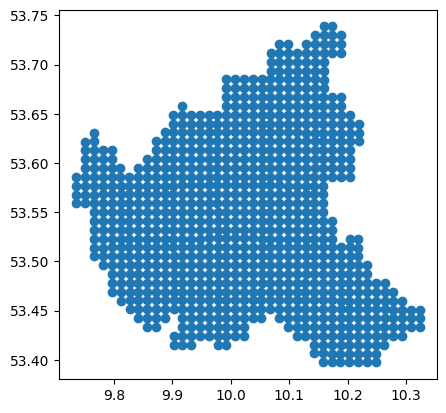

In [191]:
gdf.plot()

In [192]:
# change crs to a more precise for buffer method
# Buffer method with square as cap_style creates a square around the centroid of 840 degrees
gdf_3395 = gdf.to_crs(epsg=3395)
bbox = gdf_3395.buffer(840, cap_style=3)
bbox

0      POLYGON ((1103153.726 7026705.233, 1103153.726...
1      POLYGON ((1131630.635 7035069.700, 1131630.635...
2      POLYGON ((1104806.459 7045146.921, 1104806.459...
3      POLYGON ((1106482.769 7046827.132, 1106482.769...
4      POLYGON ((1138369.515 7046793.978, 1138369.515...
                             ...                        
857    POLYGON ((1111511.685 7065317.050, 1111511.685...
858    POLYGON ((1139987.714 7028345.404, 1139987.714...
859    POLYGON ((1136691.275 7046798.864, 1136691.275...
860    POLYGON ((1094751.254 7040095.898, 1094751.254...
861    POLYGON ((1118223.493 7033411.817, 1118223.493...
Length: 862, dtype: geometry

<AxesSubplot: >

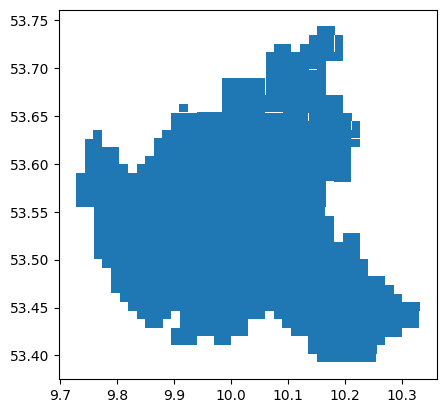

In [193]:
envgdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries(bbox))
bbox_4326 = gpd.GeoDataFrame(envgdf, crs='EPSG:3395')
bbox_4326 = bbox_4326.to_crs(epsg=4326)
bbox_4326.plot()

In [194]:
gdf['bbox'] = bbox_4326
gdf.dtypes

Einwohner             int64
Alter_D             float64
unter18_A           float64
ab65_A              float64
Auslaender_A        float64
HHGroesse_D         float64
Leerstandsquote     float64
Wohnfl_Bew_D        float64
Wohnfl_Whg_D        float64
geometry           geometry
bbox               geometry
dtype: object

In [195]:
map = folium.Map(location=[53.41535, 9.90225], tiles="CartoDB Positron", zoom_start=9, control_scale = True)
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r["bbox"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"fillColor": "orange"})
    folium.Popup(r["Alter_D"]).add_to(geo_j)
    geo_j.add_to(map)


map

In [197]:
gdf_centroid = gdf["geometry"]
gdf_bbox = gdf["bbox"]
#gdf_final = gdf[["Einwohner","Alter_D","unter18_A","ab65_A","Auslaender_A","HHGroesse_D","Leerstandsquote","Wohnfl_Bew_D","Wohnfl_Whg_D","bbox"]]
#gdf_final = gdf.rename(columns={'Auslaender_A': 'Auslaend_A','HHGroesse_D':'HHGroe_D','Leerstandsquote':'Leerstand','Wohnfl_Bew_D':'WFl_Bew','Wohnfl_Whg_D':'WFl_Whg'})
gdf_final = gdf.drop(columns=["geometry"])
gdf_final = gdf_final.set_geometry('bbox')


KeyError: "['geometry'] not found in axis"

In [ ]:

gdf_final['row_number'] = gdf_final.reset_index().index.astype(str)
gdf_final['row_number'] = "census_box"+gdf_final['row_number']
gdf_final.head()

,Einwohner,Alter_D,unter18_A,ab65_A,Auslaend_A,HHGroe_D,Leerstand,WFl_Bew,WFl_Whg,bbox,row_number
0,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0,"POLYGON ((9.90980 53.41986, 9.90980 53.41085, ...",census_box0
1,3,-9.0,0.0,100.0,0.00,-1.0,-1.0,-9.0,-1.0,"POLYGON ((10.16561 53.46473, 10.16561 53.45572...",census_box1
2,3,-9.0,0.0,0.0,0.00,-1.0,-1.0,-9.0,-1.0,"POLYGON ((9.92465 53.51871, 9.92465 53.50972, ...",census_box2
3,3,-9.0,0.0,0.0,100.00,-1.0,-1.0,-1.0,-1.0,"POLYGON ((9.93970 53.52771, 9.93970 53.51871, ...",census_box3
4,7,-9.0,-9.0,0.0,57.14,1.4,-1.0,-1.0,-1.0,"POLYGON ((10.22615 53.52753, 10.22615 53.51853...",census_box4


In [ ]:
gdf_centroid.to_file('census_centroid_data.json', driver ='GeoJSON',mode='w')
gdf_bbox.to_file('census_bbox_data.json', driver ='GeoJSON', mode='w')
gdf_final.to_file('census_final_data.json',driver ='GeoJSON', mode='w')